In [14]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
# pd.set_option('display.max_columns', 50)

In [15]:
# Load data
df = pd.read_csv("../data/Training Data_Case 3.csv", index_col=0)

In [16]:
df = df.tail(252)

<Axes: >

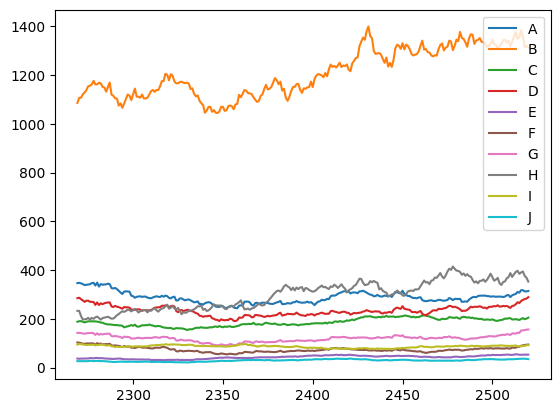

In [17]:
df.plot()

In [18]:
class Projections:
    # Get daily % returns given prices
    def make_df(self, df):
        df['shift']=df[df.columns[0]].shift(1)
        df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
        df=df.drop(columns='shift')
        return df
    # Generate list of projections
    def gen_data(self, df, first_day, runs, days):
        
        # Create list of arrays with projected daily returns
        data=[]
        first_prices=[]
        for x in range(len(df.columns)):
            temp=self.make_df(df.iloc[:,x:x+1])
            first_prices.append(temp[temp.columns[0]].iloc[first_day-1])
            data.append(np.random.laplace(loc=temp['PctChg'].mean(), scale=temp['PctChg'].std(), size=(runs, days)))
        
        # Get projected prices by applying % changes
        proj_dfs=[]
        for asset_num in range(len(data)):
            
            asset_data=[]
            for n in range(len(data[asset_num])):
                prices=[first_prices[asset_num]]
                for x in range(len(data[asset_num][n])):
                    prices.append(prices[x]*(100+data[asset_num][n][x])/100)
                asset_data.append(prices)
            
            proj_arr=np.array(asset_data)
            proj_df=pd.DataFrame()
            for x in range(proj_arr.shape[0]):
                proj_df[str(x)]=proj_arr[x]
            proj_dfs.append(proj_df)
            
        # Transform dataframes
        dfs=[]
        for run_num in range(proj_dfs[0].shape[1]):
            temp=pd.DataFrame()
            for asset_num in range(len(proj_dfs)):
                prev_df=proj_dfs[asset_num]
                temp[str(asset_num)]=prev_df[prev_df.columns[run_num]]
            dfs.append(temp)
            
        return dfs

In [19]:
class GeneticAlgorithm:
    def __init__(self, df):
        self.year_num = np.sqrt(252)
        self.returns = df
    
    def gen_weights(self, df):
        weights=np.random.randint(0, 100000, len(df.columns))
        weights=weights/sum(weights)
        return weights
    
    def gen_population(self, num_chrom, df):
        population=[]
        for x in range(num_chrom):
            population.append(self.gen_weights(df))
        return np.array(population)
    
    def evaluate_chrom(self, chromosome, dfs):    
        sharpes=[]
        for x in range(len(dfs)):
            temp=dfs[x].multiply(chromosome, axis=1)
            test=temp[list(temp.columns)].sum(axis=1).pct_change()
            sharpe=(test.mean()/test.std())*self.year_num
            sharpes.append(sharpe)
        return np.mean(sharpes)
    
    def evaluate_population(self, pop, proj_dfs):
        sharpes=[]
        for chrom in pop:
            sharpes.append(self.evaluate_chrom(chrom, proj_dfs))
        return np.array(sharpes)
    
    # Choose chromosome for next generation given the cumulataive normalized sharpes
    def choose_chrom(self, population, cum_norm_sharpes):
        for n in range(len(cum_norm_sharpes)):
            if cum_norm_sharpes[n]>np.random.rand(1)[0]:
                return population[n]
            
    def crossover(self, chrom1, chrom2):
        if np.random.rand(1)[0]>.5:
            return np.concatenate((chrom1[:int(len(chrom1)/2)], chrom2[int(len(chrom1)/2):]), axis=None)
        else:
            return np.concatenate((chrom2[:int(len(chrom1)/2)], chrom1[int(len(chrom1)/2):]), axis=None)
        
    def mutate(self, chrom, rate):
        new=[]
        for weight in chrom:
            if np.random.rand(1)[0]<rate:
                new_weight=weight*(1+np.random.normal(0, .4, 1)[0])
                if(new_weight<0):
                    new.append(0)
                else:
                    new.append(new_weight)
            else:
                new.append(weight)
        return np.array(new)
    
    def rebalance(self, chrom):
        return chrom/sum(chrom)
    
    # Create next generation of chromosomes (weights)
    def next_gen(self, sharpes, population, mutation_rate):
        
        new_gen=[]
        
        # Select best fourth
        num_chosen_direct=round(len(population)/4)
        temp={}
        for x in range(len(sharpes)):
            temp[x]=sharpes[x]
        temp={k: v for k, v in sorted(temp.items(), key=lambda item: item[1])}
        keys=list(temp.keys())[-1*num_chosen_direct:]
        for x in keys:
            new_gen.append(population[x])
        
        # Select rest through crossover: create cumulative norm fitness list
        norm_sharpes=sharpes/sum(sharpes)
        cum_norm_sharpes=[norm_sharpes[0]]
        for n in range(1, len(norm_sharpes)):
            cum_norm_sharpes.append(cum_norm_sharpes[n-1]+norm_sharpes[n])
        for x in range(len(population)-num_chosen_direct):
            new_gen.append(self.crossover(self.choose_chrom(population, cum_norm_sharpes), self.choose_chrom(population, cum_norm_sharpes)))
            
        # Mutation and rebalance
        final=[]
        for x in new_gen:
            final.append(self.rebalance(self.mutate(x, mutation_rate)))
            
        return np.array(final)
    
    def genetic_algo(self, prev_gen_sharpes, prev_gen, pop_size, mutation_rate, df, proj_dfs):
        
        # Add to high fitness weights dict
        max_sharpe=max(prev_gen_sharpes)
        best_weights=prev_gen[list(prev_gen_sharpes).index(max_sharpe)]
        high_fitness_weights[max_sharpe]=best_weights
        
        # Check convergence
        convergence=False
        if (len(high_fitness_weights)==30):
            convergence=True
        elif (len(high_fitness_weights)>1):
            if max_sharpe<list(high_fitness_weights.keys())[-2]*1.02:
                convergence_count.append(1)
            else:
                convergence_count.append(0)

            if (sum(convergence_count[-20:])==20):
                convergence=True
            else:
                convergence=False
        else:
            convergence_count.append(0)
        
        # Recursive GA
        if (convergence==False):
            print("Generation Number "+str(len(convergence_count)+1))
            print("---Processing")
            print("---Sharpe: "+str(max_sharpe))
            new_gen=self.next_gen(prev_gen_sharpes, prev_gen, mutation_rate)
            new_gen_sharpes=self.evaluate_population(new_gen, proj_dfs)
            print("---Done")
            self.genetic_algo(new_gen_sharpes, new_gen, pop_size, mutation_rate, df, proj_dfs)
        else:
            print("Convergence achieved")

In [24]:
projections = Projections()
proj_dfs = projections.gen_data(df, first_day = len(df)-30, runs = 50, days = 30)

# Define GA inputs
pop_size=25
mutation_rate=.5

model = GeneticAlgorithm(df)
gen1 = model.gen_population(pop_size, df)

# Run GA
sharpes=model.evaluate_population(gen1, proj_dfs)
high_fitness_weights={}
convergence_count=[]
model.genetic_algo(sharpes, gen1, pop_size, mutation_rate, df, proj_dfs)

C:\Users\redce\AppData\Local\Temp\ipykernel_22728\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_22728\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_22728\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.1675198593359166
---Done
Generation Number 3
---Processing
---Sharpe: 1.157204049292889
---Done
Generation Number 4
---Processing
---Sharpe: 1.2187498794142457
---Done
Generation Number 5
---Processing
---Sharpe: 1.2094693931358385
---Done
Generation Number 6
---Processing
---Sharpe: 1.2489382395654083
---Done
Generation Number 7
---Processing
---Sharpe: 1.3217283135452345
---Done
Generation Number 8
---Processing
---Sharpe: 1.3490787717288273
---Done
Generation Number 9
---Processing
---Sharpe: 1.3764518994630963
---Done
Generation Number 10
---Processing
---Sharpe: 1.4864780646474507
---Done
Generation Number 11
---Processing
---Sharpe: 1.4553557386332585
---Done
Generation Number 12
---Processing
---Sharpe: 1.6395232332736034
---Done
Generation Number 13
---Processing
---Sharpe: 1.7359542677468414
---Done
Generation Number 14
---Processing
---Sharpe: 1.9007885703593588
---Done
Generation Number 15
---Processing
---Sharpe: 1.908419473574

In [23]:
max_sharpe=max(list(high_fitness_weights.items()))[0]
best_weights=max(list(high_fitness_weights.items()))[1]
print("Max Sharpe: "+str(max_sharpe))
print("Associated Weights: "+str(best_weights))

Max Sharpe: 2.560938276034889
Associated Weights: [ 0.00108082  0.02042552  0.11171091 -0.          0.27258331  0.08133155
  0.06635142  0.06685003  0.07954295  0.30012349]
